# Team Competition-Final Model-XGBoost

Team Member: Xiaoying Zou, Xinyue Yu, Yufeng Xie

In [1]:
# pip install pmdarima

In [2]:
# !pip install --force-reinstall xgboost==1.1.0

In [3]:
# !pip install --pre pycaret

In [4]:
# import the pakages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import kpss as KPSS
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox as box
# import pmdarima as pmd
# from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  mean_absolute_percentage_error
import seaborn as sns
import itertools
from statsmodels.tsa.stattools import arma_order_select_ic as ORDER
from plotnine import * 
from statsmodels.tsa.api import ExponentialSmoothing as es
import statsmodels.formula.api as smf
import calendar
# from pycaret.time_series import *
import xgboost as xgb
import lightgbm as lgb
import plotly.express as px

In [5]:
# Dataset
df = pd.read_csv('https://raw.githubusercontent.com/Shawn-zou-2020/MyProjects/main/Timeseries%20Analysis/Datasets/CompetitionData.csv')
df.head()

,Date,Temperature,Load,Prediction
0,1/1/08 01:00,25.0,10737.0,NaN
1,1/1/08 02:00,24.0,10348.0,NaN
2,1/1/08 03:00,23.0,9997.0,NaN
3,1/1/08 04:00,23.0,9760.0,NaN
4,1/1/08 05:00,23.0,9624.0,NaN


In [6]:
# Data preprocess
df['Date'] = pd.to_datetime(df['Date'] )
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['YM'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')
df['Day'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df['Dow'] = df['Date'].dt.day_of_week+1
df['Doy'] = df['Date'].dt.dayofyear
df['Dom'] = df['Date'].dt.day
df['Woy'] = df['Date'].dt.weekofyear
df['Hour'] = df['Date'].dt.hour
df['T2'] = [i**2 for i in df['Temperature']]
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2
0,2008-01-01 01:00:00,25.0,10737.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,1,625.0
1,2008-01-01 02:00:00,24.0,10348.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,2,576.0
2,2008-01-01 03:00:00,23.0,9997.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,3,529.0
3,2008-01-01 04:00:00,23.0,9760.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,4,529.0
4,2008-01-01 05:00:00,23.0,9624.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,5,529.0


# XGBOOST

In [7]:
df1=df.copy()
df1['Load2']=df1['Load']
df1.loc[35064:,'Load2']=np.nan
# df1['lag1']=df1['Load2'].shift(1)
# df1['lag2']=df1['Load2'].shift(2)
# df1['lag3']=df1['Load2'].shift(3)
# df1['lag4']=df1['Load2'].shift(4)
# df1['lag5']=df1['Load2'].shift(5)
df1['lag23']=df1['Load2'].shift(23)
df1['lag24']=df1['Load2'].shift(24)
df1

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
0,2008-01-01 01:00:00,25.00,10737.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,1,625.0000,10737.0,NaN,NaN
1,2008-01-01 02:00:00,24.00,10348.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,2,576.0000,10348.0,NaN,NaN
2,2008-01-01 03:00:00,23.00,9997.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,3,529.0000,9997.0,NaN,NaN
3,2008-01-01 04:00:00,23.00,9760.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,4,529.0000,9760.0,NaN,NaN
4,2008-01-01 05:00:00,23.00,9624.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,5,529.0000,9624.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,2012-12-31 20:00:00,22.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,20,498.6289,NaN,NaN,NaN
43844,2012-12-31 21:00:00,20.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,21,427.2489,NaN,NaN,NaN
43845,2012-12-31 22:00:00,19.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,22,386.9089,NaN,NaN,NaN
43846,2012-12-31 23:00:00,19.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,23,373.6489,NaN,NaN,NaN


In [8]:
df['Load2']=df['Load']
df.loc[26303:,'Load2']=np.nan
# df['lag1']=df['Load2'].shift(1)
# df['lag2']=df['Load2'].shift(2)
# df['lag3']=df['Load2'].shift(3)
# df['lag4']=df['Load2'].shift(4)
# df['lag5']=df['Load2'].shift(5)
df['lag23']=df['Load2'].shift(23)
df['lag24']=df['Load2'].shift(24)
df

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
0,2008-01-01 01:00:00,25.00,10737.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,1,625.0000,10737.0,NaN,NaN
1,2008-01-01 02:00:00,24.00,10348.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,2,576.0000,10348.0,NaN,NaN
2,2008-01-01 03:00:00,23.00,9997.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,3,529.0000,9997.0,NaN,NaN
3,2008-01-01 04:00:00,23.00,9760.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,4,529.0000,9760.0,NaN,NaN
4,2008-01-01 05:00:00,23.00,9624.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,5,529.0000,9624.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,2012-12-31 20:00:00,22.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,20,498.6289,NaN,NaN,NaN
43844,2012-12-31 21:00:00,20.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,21,427.2489,NaN,NaN,NaN
43845,2012-12-31 22:00:00,19.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,22,386.9089,NaN,NaN,NaN
43846,2012-12-31 23:00:00,19.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,23,373.6489,NaN,NaN,NaN


In [9]:
df.loc[26302:26305,:]

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
26302,2010-12-31 23:00:00,48.33,10511.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,23,2335.7889,10511.0,10929.0,11709.0
26303,2011-01-01 00:00:00,41.33,10042.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,0,1708.1689,NaN,10113.0,10929.0
26304,2011-01-01 01:00:00,39.33,9627.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,1,1546.8489,NaN,9446.0,10113.0
26305,2011-01-01 02:00:00,36.67,9268.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,2,1344.6889,NaN,9031.0,9446.0


In [10]:
# splitting data into training+validation and testing
trnval=df1.iloc[:35064]
tst=df1.iloc[35064:]
tst

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
35064,2012-01-01 01:00:00,39.33,NaN,NaN,2012,1,2012-01,2012-01-01,7,1,1,52,1,1546.8489,NaN,9428.0,9970.0
35065,2012-01-01 02:00:00,40.33,NaN,NaN,2012,1,2012-01,2012-01-01,7,1,1,52,2,1626.5089,NaN,9059.0,9428.0
35066,2012-01-01 03:00:00,39.67,NaN,NaN,2012,1,2012-01,2012-01-01,7,1,1,52,3,1573.7089,NaN,8817.0,9059.0
35067,2012-01-01 04:00:00,42.33,NaN,NaN,2012,1,2012-01,2012-01-01,7,1,1,52,4,1791.8289,NaN,8743.0,8817.0
35068,2012-01-01 05:00:00,43.00,NaN,NaN,2012,1,2012-01,2012-01-01,7,1,1,52,5,1849.0000,NaN,8735.0,8743.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,2012-12-31 20:00:00,22.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,20,498.6289,NaN,NaN,NaN
43844,2012-12-31 21:00:00,20.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,21,427.2489,NaN,NaN,NaN
43845,2012-12-31 22:00:00,19.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,22,386.9089,NaN,NaN,NaN
43846,2012-12-31 23:00:00,19.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,23,373.6489,NaN,NaN,NaN


In [11]:
# splitting data into training and validation
trn = df.iloc[:26303]
val = df.iloc[26303:35064]

print(trn.shape) 
print(val.shape) 
print(tst.shape)

(26303, 17)
(8761, 17)
(8784, 17)


In [12]:
val

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
26303,2011-01-01 00:00:00,41.33,10042.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,0,1708.1689,NaN,10113.0,10929.0
26304,2011-01-01 01:00:00,39.33,9627.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,1,1546.8489,NaN,9446.0,10113.0
26305,2011-01-01 02:00:00,36.67,9268.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,2,1344.6889,NaN,9031.0,9446.0
26306,2011-01-01 03:00:00,35.33,9007.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,3,1248.2089,NaN,8763.0,9031.0
26307,2011-01-01 04:00:00,32.00,8737.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,4,1024.0000,NaN,8634.0,8763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2011-12-31 20:00:00,39.33,11812.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,20,1546.8489,NaN,NaN,NaN
35060,2011-12-31 21:00:00,39.33,11542.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,21,1546.8489,NaN,NaN,NaN
35061,2011-12-31 22:00:00,39.00,11149.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,22,1521.0000,NaN,NaN,NaN
35062,2011-12-31 23:00:00,39.33,10855.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,23,1546.8489,NaN,NaN,NaN


In [13]:
trn.tail()

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
26298,2010-12-31 19:00:00,53.33,11735.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,19,2844.0889,11735.0,12816.0,13069.0
26299,2010-12-31 20:00:00,53.33,11585.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,20,2844.0889,11585.0,12547.0,12816.0
26300,2010-12-31 21:00:00,52.33,11243.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,21,2738.4289,11243.0,12202.0,12547.0
26301,2010-12-31 22:00:00,51.33,10825.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,22,2634.7689,10825.0,11709.0,12202.0
26302,2010-12-31 23:00:00,48.33,10511.0,NaN,2010,12,2010-12,2010-12-31,5,365,31,52,23,2335.7889,10511.0,10929.0,11709.0


<Figure size 1080x720 with 0 Axes>

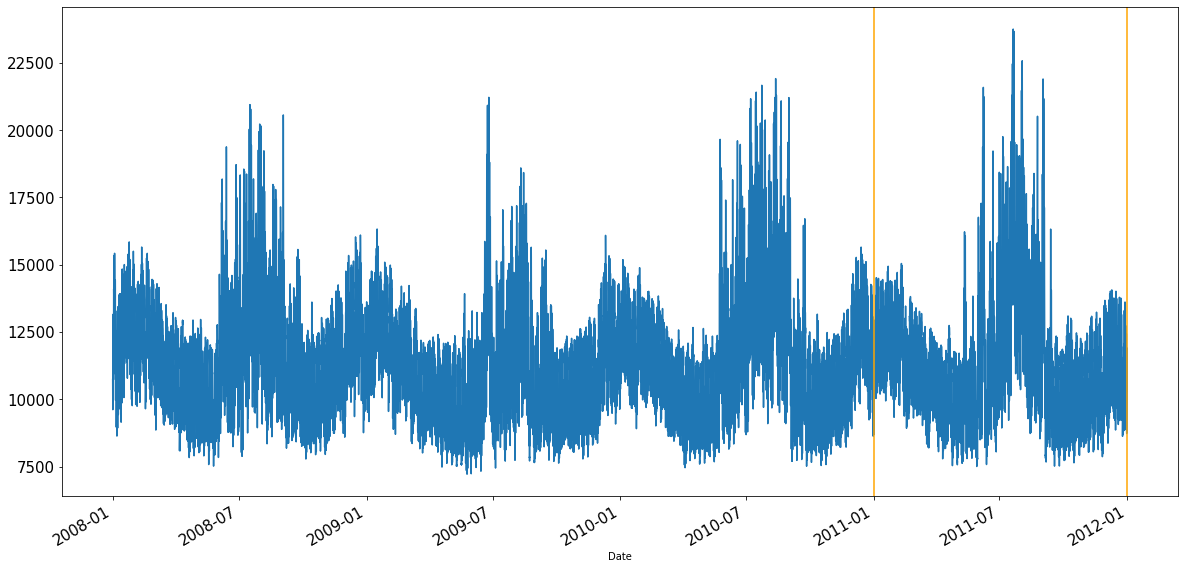

In [14]:
plt.figure(figsize=(15,10))
df.plot(y='Load',x='Date',figsize=(20,10),fontsize=15,legend=False)
plt.axvline(pd.Timestamp('2010-12-31 23:00:00'),color='orange')
plt.axvline(pd.Timestamp('2012-01-01 01:00:00' ),color='orange')

In [15]:
df.columns

Index(['Date', 'Temperature', 'Load', 'Prediction', 'Year', 'Month', 'YM',
       'Day', 'Dow', 'Doy', 'Dom', 'Woy', 'Hour', 'T2', 'Load2', 'lag23',
       'lag24'],
      dtype='object')

In [16]:
# after feature selection
trn_x=trn[['Temperature', 'Year', 'Month', 'Dow', 'Woy', 'Hour', 'T2']] #,'lag23','lag24'
trn_y=trn[['Load']]
val_x=val[['Temperature', 'Year', 'Month', 'Dow', 'Woy', 'Hour', 'T2']] #,'lag23','lag24'
val_load2=val[['Load2']]
val_y=val[['Load']]


trnval_x=trnval[['Temperature', 'Year', 'Month', 'Dow', 'Woy', 'Hour', 'T2']] #,'lag23','lag24'
trnval_y=trnval['Load']
tst_x=tst[['Temperature', 'Year', 'Month', 'Dow', 'Woy', 'Hour', 'T2']] #,'lag23','lag24'
tst_y=tst[['Load']]
tst_load2=tst[['Load2']]

In [17]:
val_x

,Temperature,Year,Month,Dow,Woy,Hour,T2
26303,41.33,2011,1,6,52,0,1708.1689
26304,39.33,2011,1,6,52,1,1546.8489
26305,36.67,2011,1,6,52,2,1344.6889
26306,35.33,2011,1,6,52,3,1248.2089
26307,32.00,2011,1,6,52,4,1024.0000
...,...,...,...,...,...,...,...
35059,39.33,2011,12,6,52,20,1546.8489
35060,39.33,2011,12,6,52,21,1546.8489
35061,39.00,2011,12,6,52,22,1521.0000
35062,39.33,2011,12,6,52,23,1546.8489


In [18]:
def get_paramsList(param_grid):
    """
    Create all possible combinations of params.
    Returns a list of all param names and a list of all param combinations.
    """
    import itertools as it
    allNames = sorted(param_grid)
    combinations = it.product(*(param_grid[Name] for Name in allNames))
    all_params = list(combinations)
    return allNames, all_params

In [19]:
# define MAPE
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def smape(actual,pred): 
    actual, pred = np.array(actual), np.array(pred)
    return 100/len(actual) * np.sum(2 * np.abs(pred - actual) / (np.abs(actual) + np.abs(pred)))

In [20]:
def modeling(modeltype,all_params,param_names,train_x,train_y,val_x,val_y): #,num
    result=pd.DataFrame(all_params,columns=param_names)
    row=0
    for i in all_params:
        result.loc[row,'model']=modeltype
        if modeltype=='lgbm':
            params = dict(zip(param_names, i))
            lgb_train = lgb.Dataset(train_x,train_y)
            lgb_valid = lgb.Dataset(val_x,val_y)
            model = lgb.train(params, lgb_train, num_boost_round=500,valid_sets=[lgb_train, lgb_valid]) #num_boost_round: Number of boosting iterations; valid_sets: List of data to be evaluated on during training
            y_val = model.predict(val_x)
            y_trn=model.predict(train_x)
        elif modeltype=='xgboost':
            params = dict(zip(param_names, i))
            model = xgb.XGBRegressor(**params)
            model.fit(train_x, train_y)

            for i in range(26303,len(val_x)+26303):
              # if np.isnan(val_x.loc[i,'lag1']):
              #   val_x.loc[i,'lag1']=val_load2.loc[i-1,'Load2']
              # if np.isnan(val_x.loc[i,'lag2']):
              #   val_x.loc[i,'lag2']=val_load2.loc[i-2,'Load2']
              # if np.isnan(val_x.loc[i,'lag23']):
              #   val_x.loc[i,'lag23']=val_load2.loc[i-23,'Load2']
              # if np.isnan(val_x.loc[i,'lag24']):
              #   val_x.loc[i,'lag24']=val_load2.loc[i-24,'Load2']
              #print(val_x.loc[[i]])  
              # y_val.loc[i] = model.predict(val_x.iloc[[i-26303,:-1]])
              val_y.loc[i,'pred']=model.predict(val_x.loc[[i]])
            
              val_load2.loc[i,'Load2']=val_y.loc[i,'pred']
            y_val=val_y['pred'].values
            y_trn=model.predict(train_x)
        val2=val.copy()
        val2['yhat']=y_val
        # trn2=trn.iloc[num:,]
        trn2=trn.copy()
        trn2['yhat']=y_trn
        
        # calculate training MAPE between observed and predicted values 
        y_true = trn2['Load'].values
        y_pred = trn2['yhat'].values
        mape0 = mape(y_true, y_pred)
        result.loc[row,'mape_trn']=mape0
        
        # calculate validation MAPE between observed and predicted values 
        y_true = val2['Load'].values
        y_pred = val2['yhat'].values
        mape1 = mape(y_true, y_pred)
        result.loc[row,'mape_val']=mape1
        row+=1
    return y_val,model,result

In [21]:
val

,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24
26303,2011-01-01 00:00:00,41.33,10042.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,0,1708.1689,NaN,10113.0,10929.0
26304,2011-01-01 01:00:00,39.33,9627.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,1,1546.8489,NaN,9446.0,10113.0
26305,2011-01-01 02:00:00,36.67,9268.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,2,1344.6889,NaN,9031.0,9446.0
26306,2011-01-01 03:00:00,35.33,9007.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,3,1248.2089,NaN,8763.0,9031.0
26307,2011-01-01 04:00:00,32.00,8737.0,NaN,2011,1,2011-01,2011-01-01,6,1,1,52,4,1024.0000,NaN,8634.0,8763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2011-12-31 20:00:00,39.33,11812.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,20,1546.8489,NaN,NaN,NaN
35060,2011-12-31 21:00:00,39.33,11542.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,21,1546.8489,NaN,NaN,NaN
35061,2011-12-31 22:00:00,39.00,11149.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,22,1521.0000,NaN,NaN,NaN
35062,2011-12-31 23:00:00,39.33,10855.0,NaN,2011,12,2011-12,2011-12-31,6,365,31,52,23,1546.8489,NaN,NaN,NaN


In [28]:
# xgboost
param_grid = {
    'learning_rate': [0.05,0.06,0.07,0.08,0.09,0.1],#
    'max_depth': [4,5,6,7,8], #10
    'booster':['gbtree', 'gblinear'] # dart
}
param_names, all_params = get_paramsList(param_grid)
y_val,model,result2=modeling('xgboost',all_params,param_names,trn_x,trn_y,val_x,val_y)

[03:47:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/panda

[03:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:48:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:49:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:49:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:49:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [29]:
result2

,booster,learning_rate,max_depth,model,mape_trn,mape_val
0,gbtree,0.05,4,xgboost,4.158004,4.331533
1,gbtree,0.05,5,xgboost,3.533651,3.892693
2,gbtree,0.05,6,xgboost,3.124553,3.781614
3,gbtree,0.05,7,xgboost,2.722374,3.690142
4,gbtree,0.05,8,xgboost,2.405176,3.685621
5,gbtree,0.06,4,xgboost,3.907896,4.144202
6,gbtree,0.06,5,xgboost,3.345449,3.785833
7,gbtree,0.06,6,xgboost,2.900172,3.694486
8,gbtree,0.06,7,xgboost,2.537408,3.619474
9,gbtree,0.06,8,xgboost,2.174288,3.643824


In [30]:
# final model
model_xgb = xgb.XGBRegressor(learning_rate=0.06,max_depth=7) 
model_xgb.fit(trnval_x, trnval_y)

for i in range(35064,len(tst_x)+35064):

  # if np.isnan(tst_x.loc[i,'lag1']):
  #   tst_x.loc[i,'lag1']=tst_load2.loc[i-1,'Load2']
  # if np.isnan(tst_x.loc[i,'lag2']):
  #   tst_x.loc[i,'lag2']=tst_load2.loc[i-2,'Load2']
  # if np.isnan(tst_x.loc[i,'lag23']):
  #   tst_x.loc[i,'lag23']=tst_load2.loc[i-23,'Load2']
  # if np.isnan(tst_x.loc[i,'lag24']):
  #   tst_x.loc[i,'lag24']=tst_load2.loc[i-24,'Load2']
  # print(tst_x.loc[[i]])  
  # y_val.loc[i] = model.predict(val_x.iloc[[i-26303,:-1]])
  tst_y.loc[i,'pred']=model_xgb.predict(tst_x.loc[[i]])

  tst_load2.loc[i,'Load2']=tst_y.loc[i,'pred']
y_tst=tst_y['pred'].values

y_trnval=model_xgb.predict(trnval_x)
mape(trnval['Load'], y_trnval)

[04:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/panda

2.6153101204326763

In [ ]:
trnval['yhat']=y_trnval
tst['yhat']=y_tst
whole_df=pd.concat([trnval,tst])
whole_df

In [ ]:
whole_df.to_csv('testing_xgboost6(learning_rate-0.06,max_depth-7).csv')

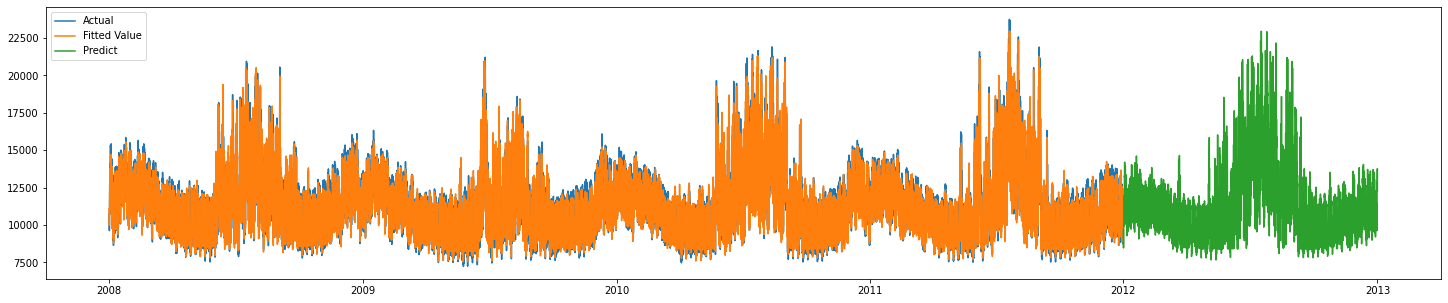

In [33]:
plt.figure(figsize=(25,5))
plt.plot(whole_df['Date'],whole_df['Load'],label='Actual')
plt.plot(whole_df['Date'].iloc[:35064],whole_df['yhat'].iloc[:35064],label='Fitted Value')
plt.plot(whole_df['Date'].iloc[35064:],whole_df['yhat'].iloc[35064:],label='Predict')
plt.legend(loc="upper left")

**Performance of XGBoost with lags**

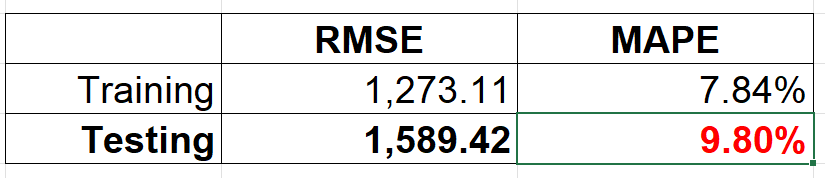

**Performance of XGBoost without lags**

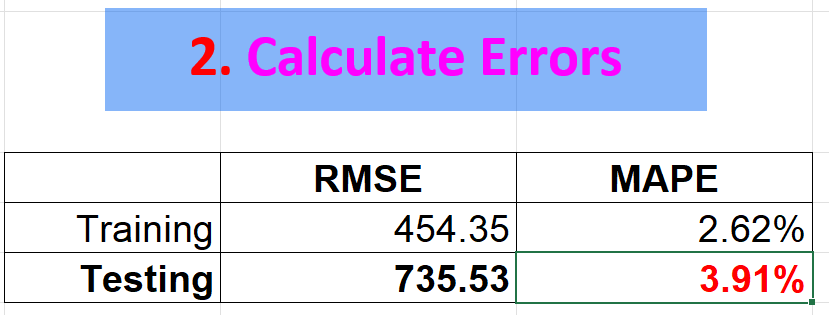

# Try LGBM

In [22]:
#lightgbm
param_grid = {
    'learning_rate': [0.1,0.3],
    'max_depth': [-1,5,10],
    'min_data_in_leaf':[5,10,20,50],
    'num_leaves': [5,10,15]
}
param_names, all_params = get_paramsList(param_grid)
y_val,model,result3=modeling('lgbm',all_params,param_names,trn_x,trn_y,val_x,val_y)

In [23]:
result3

,learning_rate,max_depth,min_data_in_leaf,num_leaves,model,mape_trn,mape_val
0,0.1,-1,5,5,lgbm,3.072162,3.640274
1,0.1,-1,5,10,lgbm,2.425006,3.612789
2,0.1,-1,5,15,lgbm,2.059293,3.632793
3,0.1,-1,10,5,lgbm,3.082284,3.650961
4,0.1,-1,10,10,lgbm,2.395897,3.606057
...,...,...,...,...,...,...,...
67,0.3,10,20,10,lgbm,1.842855,3.874154
68,0.3,10,20,15,lgbm,1.534846,4.007713
69,0.3,10,50,5,lgbm,2.515040,3.774882
70,0.3,10,50,10,lgbm,1.931309,3.949794


In [24]:
# final model
param_grid = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_data_in_leaf':20,
    'num_leaves': 10,
}
param_names, all_params = list(param_grid.keys()),list(param_grid.values())
params = dict(zip(param_names, all_params))
lgb_train = lgb.Dataset(trnval_x, trnval_y)
lgb_valid = lgb.Dataset(tst_x,tst_y)
modellgbm = lgb.train(params,lgb_train) #num_boost_round: Number of boosting iterations; valid_sets: List of data to be evaluated on during training
y_tst = modellgbm.predict(tst_x)
y_trnval=modellgbm.predict(trnval_x)
mape(trnval['Load'], y_trnval)

3.672817308238516

In [25]:
trnval['yhat']=y_trnval
tst['yhat']=y_tst
whole_df=pd.concat([trnval,tst])
whole_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Temperature,Load,Prediction,Year,Month,YM,Day,Dow,Doy,Dom,Woy,Hour,T2,Load2,lag23,lag24,yhat
0,2008-01-01 01:00:00,25.00,10737.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,1,625.0000,10737.0,NaN,NaN,11287.162710
1,2008-01-01 02:00:00,24.00,10348.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,2,576.0000,10348.0,NaN,NaN,10915.268338
2,2008-01-01 03:00:00,23.00,9997.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,3,529.0000,9997.0,NaN,NaN,10610.768719
3,2008-01-01 04:00:00,23.00,9760.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,4,529.0000,9760.0,NaN,NaN,10437.062473
4,2008-01-01 05:00:00,23.00,9624.0,NaN,2008,1,2008-01,2008-01-01,2,1,1,1,5,529.0000,9624.0,NaN,NaN,10437.062473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43843,2012-12-31 20:00:00,22.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,20,498.6289,NaN,NaN,NaN,13429.081910
43844,2012-12-31 21:00:00,20.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,21,427.2489,NaN,NaN,NaN,13429.081910
43845,2012-12-31 22:00:00,19.67,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,22,386.9089,NaN,NaN,NaN,13548.563111
43846,2012-12-31 23:00:00,19.33,NaN,NaN,2012,12,2012-12,2012-12-31,1,366,31,1,23,373.6489,NaN,NaN,NaN,13302.663662


In [26]:
whole_df.to_csv('testing_lgbm1(learning_rate-0.1,max_depth--1,min_data_in_leaf-20,num_leaves-10).csv')

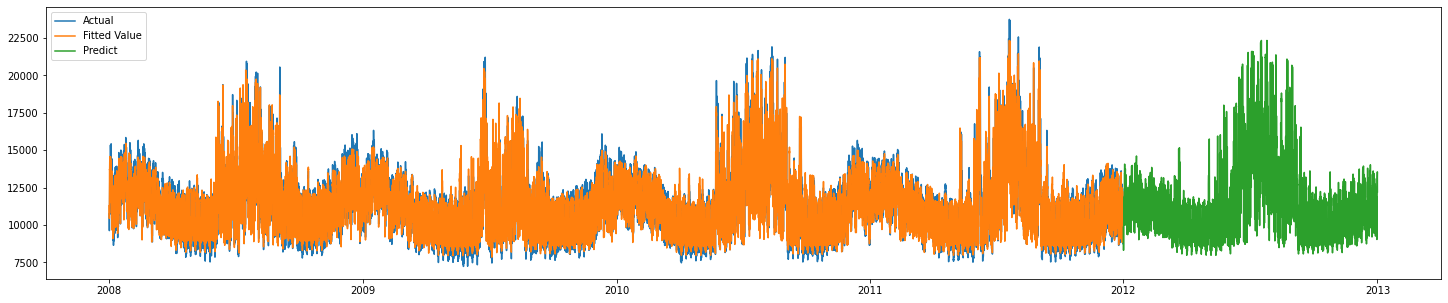

In [27]:
plt.figure(figsize=(25,5))
plt.plot(whole_df['Date'],whole_df['Load'],label='Actual')
plt.plot(whole_df['Date'].iloc[:35064],whole_df['yhat'].iloc[:35064],label='Fitted Value')
plt.plot(whole_df['Date'].iloc[35064:],whole_df['yhat'].iloc[35064:],label='Predict')
plt.legend(loc="upper left")

**Performance of LightGBM model**





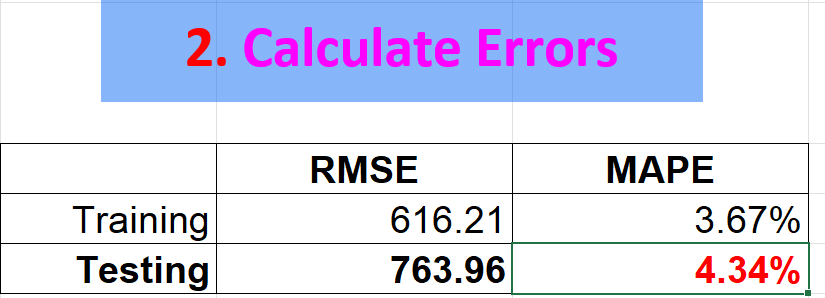